In [2]:
#export
import pandas as pd
import matplotlib.pyplot as plt 

from pathlib import Path
from fastai2.vision.all import *


In [15]:
from pdb import set_trace

In [35]:
#export 
path = Path("../data")
df_path = path/'train.csv'

In [17]:
from pprint import pprint 
pprint(path.ls())

(#5) [Path('../data/train.csv'),Path('../data/sample_submission.csv'),Path('../data/train'),Path('../data/data.npy'),Path('../data/test')]


## Preparing Data

In [18]:
df = pd.read_csv(path/'train.csv')

In [19]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [20]:

df.source.unique()

array(['usask_1', 'arvalis_1', 'inrae_1', 'ethz_1', 'arvalis_3', 'rres_1',
       'arvalis_2'], dtype=object)

In [21]:
imgs = get_image_files(path/'train')

In [22]:
len(imgs) - df['image_id'].nunique() # unlabel images 

49

In [23]:
im_df = df['image_id'].unique()
im_df = [fn + '.jpg' for fn in im_df]
im_df[:10]

['b6ab77fd7.jpg',
 'b53afdf5c.jpg',
 '7b72ea0fb.jpg',
 '91c9d9c38.jpg',
 '41c0123cc.jpg',
 'c682d8c66.jpg',
 'e46378032.jpg',
 '71fd03d51.jpg',
 '83a5d8ac8.jpg',
 '02b6f199c.jpg']

In [24]:
fns = [Path(str(path/'train') + f'/{fn}') for fn in im_df]
fns[:3]

[Path('../data/train/b6ab77fd7.jpg'),
 Path('../data/train/b53afdf5c.jpg'),
 Path('../data/train/7b72ea0fb.jpg')]

In [25]:
df_np = df.to_numpy()

In [26]:
def get_tmp_bbox(fn):
    "Grab bounding boxes from `DataFrame`"
    rows = np.where((df_np[:, 0] == fn.name[:-4]))
    bboxs = df_np[rows][:,3]
    bboxs = [b.replace('[', '').replace(']', '') for b in bboxs]
    return np.array([np.fromstring(b, sep=',') for b in bboxs])

In [27]:
def get_tmp_lbl(fn):
    "Grab label from `DataFrame`"
    rows = np.where((df_np[:, 0] == fn.name[:-4]))
    return df_np[rows][:,4]

In [28]:
fnames = df['image_id'].unique(); fnames[:3]

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb'], dtype=object)

In [29]:
bboxs = get_tmp_bbox(fns[0])
lbls = get_tmp_lbl(fns[0])

In [30]:
arr = np.array([fns[0].name[:-4], bboxs, lbls])
arr

array(['b6ab77fd7',
       array([[834., 222.,  56.,  36.],
       [226., 548., 130.,  58.],
       [377., 504.,  74., 160.],
       [834.,  95., 109., 107.],
       [ 26., 144., 124., 117.],
       [569., 382., 119., 111.],
       [ 52., 602.,  82.,  45.],
       [627., 302., 122.,  75.],
       [412., 367.,  68.,  82.],
       [953., 220.,  56., 103.],
       [ 30.,  70., 126., 133.],
       [ 35., 541.,  46.,  46.],
       [103.,  60., 117.,  83.],
       [417.,   4., 110.,  91.],
       [764., 299., 119.,  93.],
       [539.,  58.,  58., 130.],
       [139., 274., 121.,  76.],
       [461., 634., 118.,  64.],
       [215., 634., 113.,  75.],
       [134., 903., 127.,  49.],
       [737., 545.,  87.,  48.],
       [292., 930.,  43.,  46.],
       [  0., 827.,  86.,  58.],
       [324.,  44.,  57.,  70.],
       [663., 794., 116.,  64.],
       [325., 730.,  76.,  72.],
       [155., 554.,  74.,  70.],
       [783., 833.,  70.,  91.],
       [534.,  46.,  73., 224.],
       [155., 28

In [31]:
for fname in fns[1:]:
    bbox = get_tmp_bbox(fname)
    lbl = get_tmp_lbl(fname)
    arr2 = np.array([fname.name[:-4], bbox, lbl])
    arr = np.vstack((arr, arr2))

Now we have our actual data array, we need to make some adjustments. Currently our coordinates are x,y,w,h and we want x1,y1,x2,y2. So let's look at converting those!

In [32]:
for i, im in enumerate(arr[:,1]):
    for j, box in enumerate(im):
        arr[:,1][i][j][2] = box[0]+box[2]
        arr[:,1][i][j][3] = box[1]+box[3]

In [33]:
arr[0][1][0]

array([834., 222., 890., 258.])

In [34]:
np.save(f"{path}/data.npy", arr)

## DataLoader 

Let's make our true get_bbox and get_lbl. We'll want to first search our NumPy array for a matching filename, then grab the second or third index for the bounding box or the label respectivel

In [21]:
#export 
def get_bbox(fn):
    "Gets bounding box from `fn`"
    idx = np.where((arr[:,0] == fn.name[:-4]))
    return arr[idx][0][1]

In [22]:
#export
def get_lbl(fn):
    "Get's label from `fn`"
    idx = np.where((arr[:,0] == fn.name[:-4]))
    return arr[idx][0][2]

In [23]:
#export 
def get_items(noop): return fns

In [24]:
wheat = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_items,
                 splitter=RandomSplitter(),
                 get_y=[get_bbox, get_lbl],
                 item_tfms=Resize(256, method=ResizeMethod.Pad),
                 n_inp=1)

In [25]:
dls = wheat.dataloaders(path,bs=32)

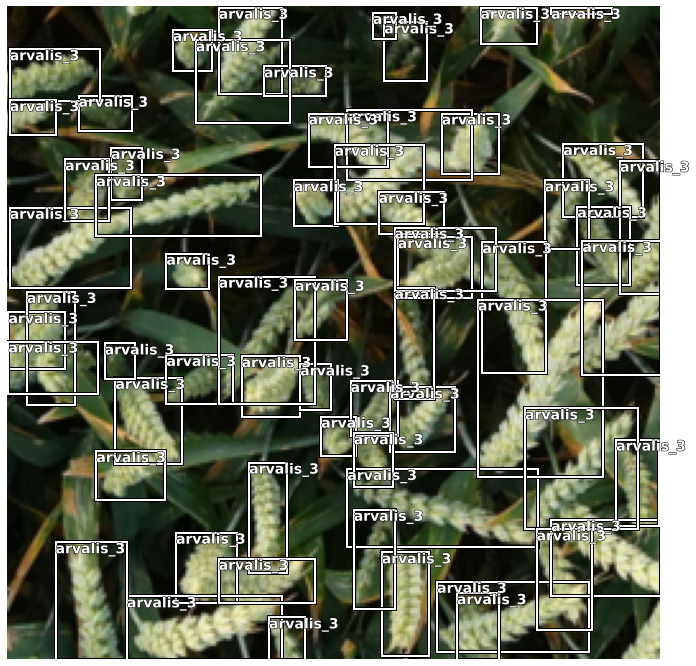

In [26]:
dls.show_batch(max_n=1, figsize=(12,12))

## Traning Net 

!pip install -u effdet timm omegaconf

In [27]:
path

Path('/home/nithin/Documents/kaggle/global-wheat-detection/data')

In [36]:
#export
pre_trained_weights = path.parent / "models/efficientdet_d0-d92fd44f.pth"

In [29]:
#export 
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d0')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load(pre_trained_weights)
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)


In [ ]:

effdet = get_net()